# Genome Mining Notebook

## Configuration

Here are the parameters that you should edit for each run. The **runName** will be the name of the run, the **pattern** is the pattern to search lasso peptides against, the **cutoffRank** is the minimum required rank to run, the **genomeDir** is the directory where the FASTA and FNA files to be mined are stored, the **database** is where you would like the database to be written to, and **outputLogs** is where the output should be written to.

**models** is a list of models to generate motifs for and search with.

**memeDir** is the directory where the meme suite was installed on this computer, and **localMotifDir** is some empty or nonexistent directory that this program can use as scratch space.

In [1]:
import yaml
config = yaml.safe_load('''
# Setup parameters for a genome mining run

## Parameters for each run
runName: "controls11_17"
pattern: 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*'
cutoffRank: 0
genomeDir: "/home/blucheez/Projects/lassomining/genomes/"
database: "/home/blucheez/Projects/lassomining/output/matches.db"
motifs:
  - "/home/blucheez/Projects/lassomining/motifs/b_meme.xml"
  - "/home/blucheez/Projects/lassomining/motifs/c_meme.xml"
  
## Parameters you should not have to change
memeDir: "/home/blucheez/meme"
''')

Below is a lot of the logic behind the mining, but just provides a series of functions to be used in the following code block

## Mining
Here are the commands for actually running the genome mining software. Output is printed below this block as it progresses, and this is the slowest running part of the program.

In [2]:
import traceback
import sys
import os
import time
import shutil
import json
from pathlib import Path
from mining import mine

In [3]:
runName = config["runName"]
pattern = config["pattern"]
cutoffRank = config["cutoffRank"]
genomeDir = config["genomeDir"]
databaseDir = config["database"]
motifs = config["motifs"]
memeDir = config["memeDir"]
print("Beginning run " + runName)
print("cutting off hits below " + str(cutoffRank))
print("searching for pattern " + pattern)
print("Using these motifs:")
print(motifs)
print("Genomes being read from " + str(genomeDir))
print("writing output to " + databaseDir)

Beginning run controls11_17
cutting off hits below 0
searching for pattern M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Using these motifs:
['/home/blucheez/Projects/lassomining/motifs/b_meme.xml', '/home/blucheez/Projects/lassomining/motifs/c_meme.xml']
Genomes being read from /home/blucheez/Projects/lassomining/genomes/
writing output to /home/blucheez/Projects/lassomining/output/matches.db


In [4]:
try:
    # start a timer
    t0 = time.time()
    
    # store meta data about the particular run
    runStatus = {
        "name": runName,
        "pattern": pattern,
        "input": [],
        "progress": 0.0,
        "peptides": 0,
        "cutoff": cutoffRank
    }
    
    ## create filepaths
    # create genome folder if not already there
    if not os.path.exists(genomeDir):
        print("could not find " + genomeDir + ", attempting to make it")
        os.makedirs(genomeDir)
    # create output database if not already there
    path = databaseDir.split("/")
    databaseFolder = "/".join(path[0:len(path) - 1])
    if not os.path.exists(databaseFolder):
        print("creating database directory " + databaseFolder)
        os.makedirs(databaseFolder)
    if not os.path.exists(databaseDir):
        print("Could not find " + databaseDir + ", attempting to create...")
        Path(databaseDir).touch()
       
    mine(genomeDir, runName, pattern, cutoffRank, databaseDir, memeDir, motifs)
    print("finished all the runs for " + runName)
    
except Exception as error: 
    print("An error occured while mining")
    traceback.print_tb(sys.exc_info()[2])
    print(str(error))

translating fna files in directory folder /home/blucheez/Projects/lassomining/genomes/
Opening up GCA_000005845.2_ASM584v2_genomic.fna and converting into peptide sequences...
Read 1 objects from FASTA file /home/blucheez/Projects/lassomining/genomes/GCA_000005845.2_ASM584v2_genomic.fna
converting 4641652 base pairs from U00096.3 Escherichia coli str. K-12 substr. MG1655, complete genome
created 6 peptide sequences from U00096.3 Escherichia coli str. K-12 substr. MG1655, complete genome
writing read peptides into '/home/blucheez/Projects/lassomining/genomes/GCA_000005845.2_ASM584v2_genomic.faa'
scanning GCA_000005845.2_ASM584v2_genomic.fna for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/genomes/GCA_000005845.2_ASM584v2_genomic.faa
Found 11 peptides in this set of ORFs
found 11 peptides
removing /home/blucheez/Projects/lassomining/genomes/GCA_000005845.2_ASM584v2_genomic.faa
finished all the runs for controls11_17


## Lasso Viewer

A rudimentary method of looking at lassos within this notebook.

In [2]:
import sqlite3
import pandas as pd

In [3]:
# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)

In [4]:
c = conn.cursor()
selection_string = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinct_genomes = []
for row in c.execute(selection_string):
    distinct_genomes.append(row[0])

c.close()
print(distinct_genomes)

['Escherichia coli']


In [76]:
import json
genome = distinct_genomes[0]
c = conn.cursor()
selection_string = f'SELECT DISTINCT sequence, start, end, overallLength, rank, orf, closestOrfs FROM lassopeptides WHERE runname is "{config["runName"]}" AND genome is "{genome}"'
lasso_peptides = []
for row in c.execute(selection_string):
    lasso_peptides.append({
        "sequence": row[0],
        "start": row[1],
        "end": row[2],
        "overallLength": row[3],
        "rank": row[4],
        "orf": row[5],
        "closestOrfs": decode(json.loads(row[6]))
    })

c.close()

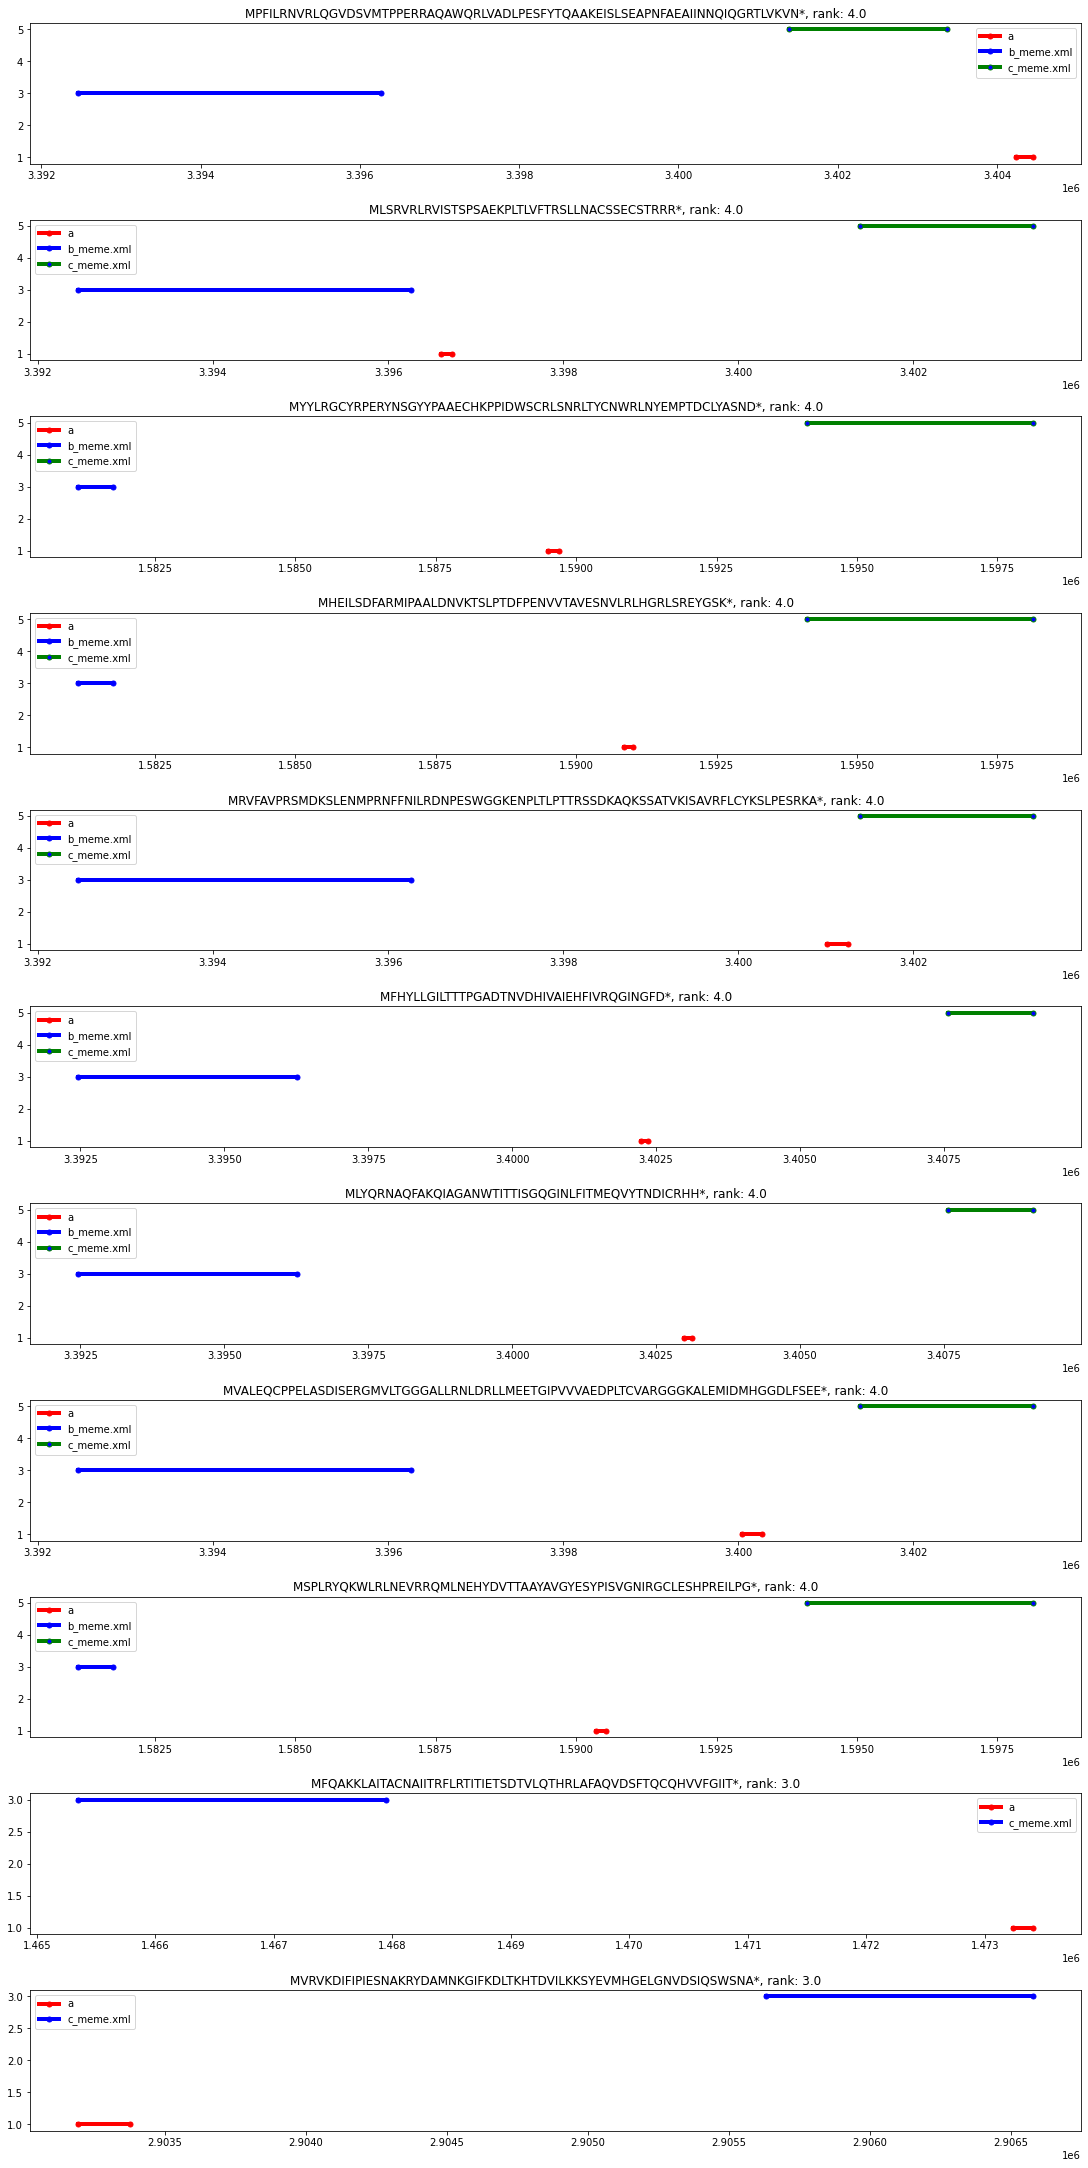

In [77]:
fig, axs = plt.subplots(len(lasso_peptides), 1, figsize=(15,30), constrained_layout=True)

color_arr = ['blue', 'green', 'yellow', 'purple', 'brown', 'cyan']
count = 0
for lasso in lasso_peptides:
    a = {'x': [lasso["start"], lasso["end"]], 'y': [1, 1]}
    axs[count].plot( a['x'], a['y'], label='a', marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=4)
    inner_count = 0
    for closeOrf in lasso['closestOrfs']:
        axs[count].plot( [closeOrf['start'], closeOrf['end']], [3 + (2 * inner_count), 3 + (2 * inner_count)], label=closeOrf["motifType"],  marker='o', markerfacecolor='blue', markersize=5, color=color_arr[inner_count % len(color_arr)], linewidth=4)
        inner_count += 1
    axs[count].set_title(f'{lasso["sequence"]}, rank: {lasso["rank"]}')
    _ = axs[count].legend()
    count += 1

plt.show()

## Graphical Genome-wide representations
Plots the rank distribution of the peptides found - a straight line indicates non discrimination occured while ranking, whereas a steep cutoff indicates that the "good" hits were strongly separated from noise.

In [41]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)

In [42]:
c = conn.cursor()
selection_string = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinct_genomes = []
for row in c.execute(selection_string):
    distinct_genomes.append(row[0])

c.close()
print(distinct_genomes)

['Escherichia coli']


In [52]:
genome_ranks = {}
c = conn.cursor()
for genome in distinct_genomes:
    selection_string = f'SELECT rank FROM lassopeptides WHERE runname is "{config["runName"]}" AND genome is "{genome}"'
    ranks = []
    for row in c.execute(selection_string):
        ranks.append(row[0])
    ranks.sort(reverse=True)
    genome_ranks[genome] = ranks
c.close()

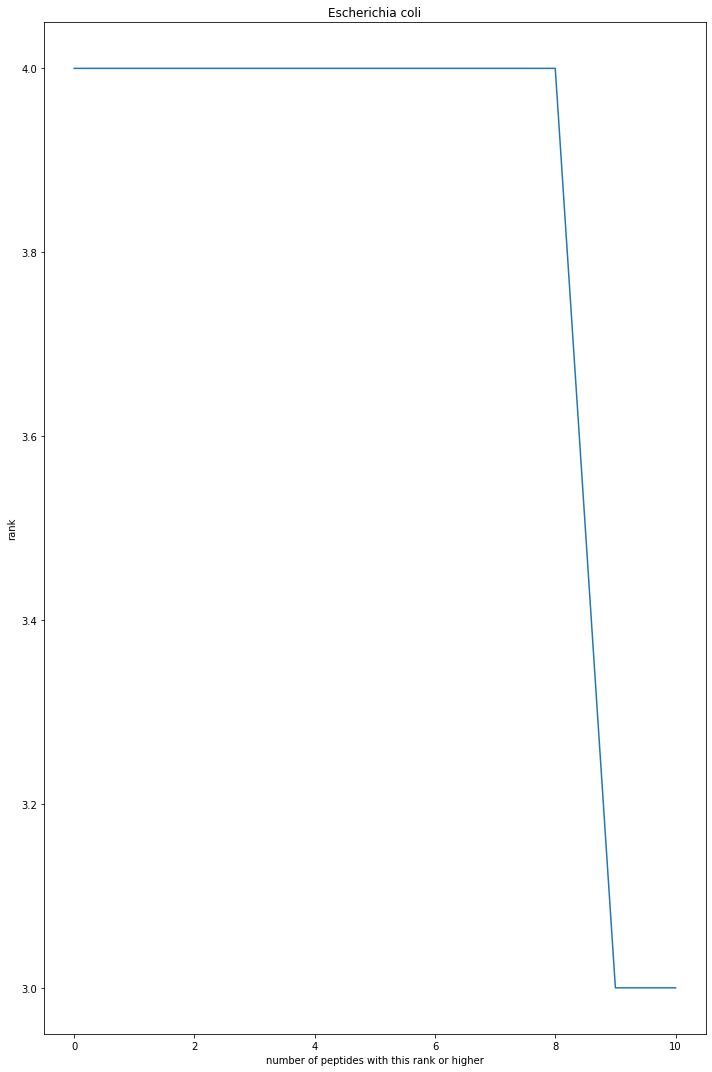

In [55]:
fig, axs = plt.subplots(len(distinct_genomes), 1, figsize=(10,15))

for genome in genome_ranks.keys():
    y = genome_ranks[genome]
    x = range(0, len(y))
    axs.plot(x, y)
    axs.set_title(genome)
    axs.set(xlabel="number of peptides with this rank or higher", ylabel="rank")

plt.tight_layout()
plt.show()

## Export
Export data to CSVs and Firebase

In [5]:
from mining import export_to_csv
if(not os.path.isdir('output/csvs')):
    os.mkdir('output/csvs')
export_to_csv(config["runName"], config["database"], os.path.join('output', 'csvs'))

Exporting results of run controls11_2
Number of genomes with lasso peptides: 6
DISTINCT lasso peptide hits: 90
Exporting output/csvsBacillus halodurans.csv
Exporting output/csvsMycobacterium tuberculosis.csv
Exporting output/csvsPseudomonas aeruginosa.csv
Exporting output/csvsEscherichia coli.csv
Exporting output/csvsMycobacterium smegmatis.csv
Exporting output/csvsTPA_asm: Burkholderia.csv


In [6]:
from mining import export_to_firebase, clear_firebase

In [7]:
clear_firebase('/home/blucheez/Projects/lassomining/lasso-peptides-51ce2e6250b9.json')

Deleting doc Bacillus halodurans => {}
Deleting doc Escherichia coli => {}
Deleting doc Mycobacterium smegmatis => {}
Deleting doc Mycobacterium tuberculosis => {}
Deleting doc Pseudomonas aeruginosa => {}
Deleting doc TPA_asm: Burkholderia => {}
Deleting doc MAADFPRYTAARDGDKPVDWTRIRRSGNDGRRHRMLGSRFDSGGEAKHFLAISLAGA*120604-120778Mycobacterium tuberculosis => {'orf': 2, 'accession': 'AL123456.3', 'start': 120604, 'end': 120778, 'runName': 'controls11_2', 'sequence': 'MAADFPRYTAARDGDKPVDWTRIRRSGNDGRRHRMLGSRFDSGGEAKHFLAISLAGA*', 'closestOrfs': '"[{\'start\': 109843, \'end\': 117535, \'count\': 2, \'motifs\': [{\'strand\': 3, \'motif\': \'3\', \'start\': 36942, \'end\': 36955, \'score\': 938.74, \'p-value\': 1.36e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 2, \'motif\': \'2\', \'start\': 37435, \'end\': 37449, \'score\': 1059.45, \'p-value\': 7.13e-06, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': 

Deleting doc MAWGIIKAKTMKLSPCVFSPIRVAYVGRKPNMVVKIMLWAMIDKNDTFKRRGSRITEDRSPS*2433175-2433364Bacillus halodurans => {'rank': 4.0, 'orf': 2, 'sequence': 'MAWGIIKAKTMKLSPCVFSPIRVAYVGRKPNMVVKIMLWAMIDKNDTFKRRGSRITEDRSPS*', 'runName': 'controls11_2', 'closestOrfs': '"[{\'start\': 2440768, \'end\': 2442688, \'count\': 2, \'motifs\': [{\'strand\': 3, \'motif\': \'3\', \'start\': 586559, \'end\': 586572, \'score\': 1404.58, \'p-value\': 1.52e-06, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 4, \'motif\': \'4\', \'start\': 586849, \'end\': 586859, \'score\': 881.52, \'p-value\': 4.64e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -3, \'motifType\': \'b_meme.xml\', \'sequence\': \'*RQMETIRLTTAQALIKFLNQQYVHSDGEEFPFVEGIFNIFGHGNVLGIGHALEQDPGHLKVYQGKNEQGMAHTAIAYSKQMLRKKIYAITTSSGPGSANLVTAAATALANQIPILLLPADTYATRQPDPVLQQFEQEQSIAITTNDALQPVSRYWDRITRPEQLMSSLIRAFEVMTDPAKAGPATICISQDVEGEAFDYDVRFFEKRVHYIDRKLPSERELKGAADLIKK

Deleting doc MFSRSCSSDVAPIRLLVTNGRLLTNASASCAGDRPCRFASAT*222687-222816TPA_asm: Burkholderia => {'runName': 'controls11_2', 'start': 222687, 'rank': 2.0, 'end': 222816, 'genome': 'TPA_asm: Burkholderia', 'closestOrfs': '"[{\'start\': 218485, \'end\': 219547, \'count\': 1, \'motifs\': [{\'strand\': 3, \'motif\': \'3\', \'start\': 72874, \'end\': 72887, \'score\': 641.12, \'p-value\': 4.91e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': 3, \'motifType\': \'b_meme.xml\', \'sequence\': \'*FAPRRERAMMRCTKSSNVRRDEASALKQCDRCTRMARSYCTIPIDIHLPMSVAPIDFQAVEKRYDGKLVVNGLSFHVQPGECFGLLGPNGAGKTTTLKMLLGITYPDAGSISLCGESVPSRARHARRRVGVVPQFDNLDPDFTVRENLIVFARYFGLSAHEARSLVPSLLAFAKLENKADARVSELSGGMKRRLTLARALVNDPDVLVLDEPTTGLDPQARHLMWERLRSLLGRGKTILLTTHFMEEAERLCHRLCVIEEGRKIAEGAPRALIETEIGCDVIEIYGPDPVQLRDELAPLAKRTEISGETLFCYVDDPEPINARLKGRTGLRYLHRPANLEDVFLRLTGREMQD\'}, {\'start\': 212471, \'end\': 214403, \'count\': 1, \'motifs\': [{\'strand\': 2, \'motif\': \'2\', \'start

Deleting doc MGLNPRESNRRSERTSSASLGRTVRSGARSGRDRAPLR*186765-186882TPA_asm: Burkholderia => {'orf': 1, 'start': 186765, 'overallLength': 235608, 'end': 186882, 'runName': 'controls11_2', 'rank': 2.0, 'closestOrfs': '"[{\'start\': 181509, \'end\': 184737, \'count\': 1, \'motifs\': [{\'strand\': 2, \'motif\': \'2\', \'start\': 17899, \'end\': 17913, \'score\': 852.9, \'p-value\': 1.78e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -1, \'motifType\': \'b_meme.xml\', \'sequence\': \'*RRSSAARPRNRPPGRLRPPRPRRAKPDKHNSIMARFFIDRPVFAWVISLFIMLGGIFAIRALPVAQYPDIAPPVVSIYATYPGASAQVIEESVTAVIEREMNGVPGLLYTSATSSAGQASLYLTFKQGVSADLAAVDVQNRLKTVEARLPEPVRRDGISVEKAADNIQLVVSLTSEDGRMSAVQLGEYASANVVQALRRVEGVGKVQFWGAEYAMRIWPDPVKLAALNLTASDIATAVRAHNARVTIGDIGRSAVPDSAPIAATVLADAPLSTPDAFGAIALRARADGSTLYLRDVAKIEFGGNDYNYPSFVNGKTATGMGIKLAAGSNAVATEKRVRATMDELSKFFPPGVTYQIPYETSSFVRVSMQKVVTTLIEAGVLVFAVMFLFMQNFRATLIPTLVVPVALLGTFGAMLAAGFSINVLTMFGMVLAIGILVDDAIVVVENVERLMVEEKLPPYEATVKAMK

Deleting doc MKNAYPFFHRYKGKLALVAMAVQEPTLTYTNPRTRKPFTRDEFVDYAQDYLGADLIFWSTKSPWLNGK*108966-109173TPA_asm: Burkholderia => {'start': 108966, 'genome': 'TPA_asm: Burkholderia', 'orf': 1, 'rank': 2.0, 'closestOrfs': '"[{\'start\': 103480, \'end\': 104965, \'count\': 1, \'motifs\': [{\'strand\': 1, \'motif\': \'1\', \'start\': 34722, \'end\': 34742, \'score\': -353.85, \'p-value\': 8.97e-06, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': 3, \'motifType\': \'b_meme.xml\', \'sequence\': \'*RFHNASDSSMMCTPKRRPPIERGDATVICRPAYPLINMERTMNFSMLSRFVPRAIAAGCLFAAAGASQAAGAYAPYVDVTLYPTPLVDQIGVQQGIQQFMLAFVVSGGNQCAPSWGGVQPIGNGATGDLLNTIATSVSNYRAKGGDVAVSFGGAAGLPLMQACSSVAALKGAYQTVIDTYSLTHVDFDIEGASQQDSAAVTRNFQAVAQLQADYAAKGKPLHVTLTLPAMPTGLVQDGLNVLNAALANNVTLDAVNIMTMDYGPAGIDMGAAAISAAQGLYSQLDTAYKSVGKPQTDAQLKQLVGVTPMIGVNDVQGETFTLANAQSVQTTAANNNYGFVGIWSITRDKACDGGSQYASPICSGVAQQPYAFSSIFKQLGGQWGSGVTQDPNYGGGSDGGGKPQPGAPWSATQVYTAGATVTYQGTTYQAQWWTQGDIPGQSSVWKPIGGNAPAWSSTTAYPAGACVM

Deleting doc MLWAIGVHAFGAGAFSAEGAPFIRSCSTRLAVVNIMRRCRNTSTTSFSWMRADCSSCRKAV*23368-23554TPA_asm: Burkholderia => {'accession': 'CADEQG010000012.1', 'sequence': 'MLWAIGVHAFGAGAFSAEGAPFIRSCSTRLAVVNIMRRCRNTSTTSFSWMRADCSSCRKAV*', 'end': 23554, 'genome': 'TPA_asm: Burkholderia', 'start': 23368, 'runName': 'controls11_2', 'rank': 2.0, 'orf': -3, 'closestOrfs': '"[{\'start\': 22482, \'end\': 23211, \'count\': 1, \'motifs\': [{\'strand\': 1, \'motif\': \'1\', \'start\': 7655, \'end\': 7675, \'score\': -991.41, \'p-value\': 6.6e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': 1, \'motifType\': \'b_meme.xml\', \'sequence\': \'*ARAGHHSRGTDALSAFFFGAAMSNVALHTRRVVVADDHPIVLRAVTDYVNSLAGFHVVASVSSGDALLSAMREQEANLVVTDFTMHQANDDKDGLRLISHLMRAYERTPIIVFTMLTNSGVISQLCRMGVAGLVGKEEEIAELGRVCLSVARGVGQSLSPGMAHRLAAVGSIRPGEAAFNALTPKELEVVRLFTGGMSLTDIARTLNRSLGTVSTQKRSAMRKLHVDTNVDLINCAREQGLL\'}, {\'start\': 19444, \'end\': 20620, \'count\': 1, \'motifs\': [{\'strand\': 3, \'mo

Deleting doc MNHPVLIHHDRLIPLGNGTNSNRPFRSDDFGFNMVPMGTVSTSYKQTDRLIVKANHCCPSFSIAKLSKFRP*2343838-2344054Bacillus halodurans => {'genome': 'Bacillus halodurans', 'sequence': 'MNHPVLIHHDRLIPLGNGTNSNRPFRSDDFGFNMVPMGTVSTSYKQTDRLIVKANHCCPSFSIAKLSKFRP*', 'start': 2343838, 'accession': 'BA000004.3', 'rank': 4.0, 'closestOrfs': '"[{\'start\': 2347695, \'end\': 2349960, \'count\': 2, \'motifs\': [{\'strand\': 2, \'motif\': \'2\', \'start\': 617801, \'end\': 617815, \'score\': 561.3, \'p-value\': 6.05e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 4, \'motif\': \'4\', \'start\': 617897, \'end\': 617907, \'score\': 753.48, \'p-value\': 8.12e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -1, \'motifType\': \'b_meme.xml\', \'sequence\': \'*FVEGEPMPIFYTEQTKEFHLQTKGSSYIFTVLDNQQLGHLYYGKKIEHRDSFTHLLRFQRRATSSCVFEGNLEFSLDLIKQEFPSYGTTDYREPAFQILQENGSRITNFEYKNHVISSGKKPLKGLPATYVESEEEAATLEVFLYDSLIDVELVLTYTVFAETNVITRHARFI

Deleting doc MPPAVPRVGALPARLLRPKSPEESNASRNSWWAVIPSTRRRGTSDRTQAGSQDAGRACTRRGSGSWHFPNPEADARELR*6017875-6018115Mycobacterium smegmatis => {'orf': 2, 'runName': 'controls11_2', 'genome': 'Mycobacterium smegmatis', 'start': 6017875, 'overallLength': 6983265, 'end': 6018115, 'closestOrfs': '"[{\'start\': 6009804, \'end\': 6012459, \'count\': 3, \'motifs\': [{\'strand\': 3, \'motif\': \'3\', \'start\': 324100, \'end\': 324110, \'score\': 551.92, \'p-value\': 2.54e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/c_meme.xml\'}, {\'strand\': 3, \'motif\': \'3\', \'start\': 324311, \'end\': 324321, \'score\': 181.48, \'p-value\': 8.97e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/c_meme.xml\'}, {\'strand\': 1, \'motif\': \'1\', \'start\': 324440, \'end\': 324460, \'score\': -369.88, \'p-value\': 7.24e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/c_meme.xml\'}], \'readingFrame\': -1, \'motifType\': \'c_meme.xml\', \'sequence\': \'*RSTPDADTIFAVRGTAGAS

Deleting doc MRPADRTLFALRPADVAGGVHGPPAGSRAARARTAHRAAGAGPDLGRAGWNDDHTVRAGAVHDGV*1147527-1147725Mycobacterium tuberculosis => {'genome': 'Mycobacterium tuberculosis', 'rank': 4.0, 'orf': 1, 'end': 1147725, 'runName': 'controls11_2', 'accession': 'AL123456.3', 'overallLength': 4411530, 'start': 1147527, 'sequence': 'MRPADRTLFALRPADVAGGVHGPPAGSRAARARTAHRAAGAGPDLGRAGWNDDHTVRAGAVHDGV*', 'closestOrfs': '"[{\'start\': 1138951, \'end\': 1142668, \'count\': 2, \'motifs\': [{\'strand\': 4, \'motif\': \'4\', \'start\': 380404, \'end\': 380414, \'score\': 893.16, \'p-value\': 4.4e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 3, \'motif\': \'3\', \'start\': 380463, \'end\': 380476, \'score\': 524.66, \'p-value\': 7.94e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': 2, \'motifType\': \'b_meme.xml\', \'sequence\': \'*NGRIMTAPGPACSDTPIAGLVELALSAPTFQQLMQRAGGRPDELTLIAPASARLLVASALARQGPLLVVTATGREADDLAAELRGVFGDAVAL

Deleting doc MRSAPGPRTGSPASAIPPPAGATKPAIAFSNVDLPQPDGPSSTKRSAP*192771-192918TPA_asm: Burkholderia => {'sequence': 'MRSAPGPRTGSPASAIPPPAGATKPAIAFSNVDLPQPDGPSSTKRSAP*', 'genome': 'TPA_asm: Burkholderia', 'runName': 'controls11_2', 'start': 192771, 'orf': 1, 'accession': 'CADEQG010000012.1', 'rank': 2.0, 'end': 192918, 'overallLength': 235608, 'closestOrfs': '"[{\'start\': 192239, \'end\': 193157, \'count\': 1, \'motifs\': [{\'strand\': 2, \'motif\': \'2\', \'start\': 14225, \'end\': 14239, \'score\': 561.3, \'p-value\': 6.05e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -2, \'motifType\': \'b_meme.xml\', \'sequence\': \'*HLLDWDSRPLSQRAFFLIVPAGRDGVRRMAAEPSTLFANPADAASGRATSGKLLAVDRVTLEYRSRERVVRATQQVSFDVYGADRFVLLGPSGCGKSTLLKAIAGFVAPAGGGIALAGEPVRGPGADRIVVFQEFDQLPPWKTVLENVMFPLRAAKKLPRAEAAERARSALDKVGLSAFADAYPHTLSGGMKQRVAIARALAMEPRVLLMDEPFAALDALTRRRMQHELLRLWDDARFTLLFVTHSIEEALVIGNRILLLSPHPGRVRAELNSHHFDESSIGRADFQRTAERIHRLLFEEHGTHA\'}, {\'start\': 1

Deleting doc MSSTDMSHSSVARASQRSAAPSSKCRMKVSTVFIAASCATSTPLGSPVEPEVNNT*2673591-2673759Mycobacterium tuberculosis => {'start': 2673591, 'sequence': 'MSSTDMSHSSVARASQRSAAPSSKCRMKVSTVFIAASCATSTPLGSPVEPEVNNT*', 'accession': 'AL123456.3', 'orf': 1, 'end': 2673759, 'closestOrfs': '"[{\'start\': 2667255, \'end\': 2670339, \'count\': 2, \'motifs\': [{\'strand\': 4, \'motif\': \'4\', \'start\': 580602, \'end\': 580612, \'score\': 800.04, \'p-value\': 6.64e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 2, \'motif\': \'2\', \'start\': 581361, \'end\': 581375, \'score\': 500.55, \'p-value\': 7.72e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -1, \'motifType\': \'b_meme.xml\', \'sequence\': \'*PRDRFDAGHRFRARAWPRVWGGVMAPKQLPDGRVAVLLSAHAEELIGPDARAIADYLERFPATTVTEVARQLRKTRRVRRHRAVLRAADRLELAEGLRALAAGREHPLIARSSLGSAPRQAFVFPGQGGHWPGMGAVAYRELPTYRTATDTCAAAFAAAGVDSPLPYLIAPPGTDERQAFCEIEIEGAQFVHAVALAEVWRSCGVLPDLTVGHSLGE

Deleting doc MTHAPRNGGEAHHARNGLIEACLHLYLLNRGVLLTPFHNMALTCPATRAEDVELHDRLLRDCLGELLERPS*4572097-4572313Pseudomonas aeruginosa => {'genome': 'Pseudomonas aeruginosa', 'overallLength': 6264402, 'accession': 'NC_002516.2', 'closestOrfs': '"[{\'start\': 4580577, \'end\': 4582719, \'count\': 2, \'motifs\': [{\'strand\': 4, \'motif\': \'4\', \'start\': 560734, \'end\': 560744, \'score\': 1056.12, \'p-value\': 2.09e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 2, \'motif\': \'2\', \'start\': 561179, \'end\': 561193, \'score\': 585.6, \'p-value\': 5.48e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -1, \'motifType\': \'b_meme.xml\', \'sequence\': \'*PRLPGGALKPQQRAHVDHQLQADDETVSAQFASAGVVVVVRVEDVLHRRLQRDVRGQCDVRIGFQGVHVALAEFRIAASGDPRLALELQLVIVQAQVAGLEVELVPRAVEGRMVGQAQLGEMTERLLVVGRYRQRAEQPQRPRRIEAAAVGAPEQLLELEEAAGAAVVAGAGERVDLVGGVQVGVEFIVRAVGIEAFLALVADPQQQAGAAGVVGAEIEAMALLQVIHRVGLEGPGVQVQGRGRPVLQVAAPGAVGRR

Deleting doc MVKLTKKQIADVTGFQTVITTTAGDRSVGAKAQLPESEVAKLPAHM*3395823-3395964Escherichia coli => {'overallLength': 4641651, 'runName': 'controls11_2', 'closestOrfs': '"[{\'start\': 3392459, \'end\': 3396263, \'count\': 2, \'motifs\': [{\'strand\': 1, \'motif\': \'1\', \'start\': 416060, \'end\': 416080, \'score\': -643.65, \'p-value\': 2.27e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 1, \'motif\': \'1\', \'start\': 416285, \'end\': 416305, \'score\': -1078.35, \'p-value\': 8.54e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': -2, \'motifType\': \'b_meme.xml\', \'sequence\': \'*RVRRLPGILLLTGAALVVIAALLVSGLRIALPHLDAWRPEILNKIESATGMPVEASQLSASWQNFGPTLEAHDIRAELKDGGEFSVKRVTLALDVWQSLLHMRWQFRDLTFWQLRFRTNTPITSGGSDDSLEASHISDLFLRQFDHFDLRDSEVSFLTPSGQRAELAIPQLTWLNDPRRHRAEGLVSLSSLTGQHGVMQVRMDLRDDEGLLSNGRVWLQADDIDLKPWLGKWMQDNIALETAQFSLEGWMTIDKGDVTGGDVWLKQGGASWLGEKQTHTLSVDNLTAHITRENPGWQFSIPDTRITMDGKPWPSGALTLAWIP

Deleting doc MYYLRGCYRPERYNSGYYPAAECHKPPIDWSCRLSNRLTYCNWRLNYEMPTDCLYASND*1589505-1589685Escherichia coli => {'start': 1589505, 'overallLength': 4641651, 'orf': 1, 'runName': 'controls11_2', 'accession': 'U00096.3', 'genome': 'Escherichia coli', 'closestOrfs': '"[{\'start\': 1581126, \'end\': 1581750, \'count\': 2, \'motifs\': [{\'strand\': 2, \'motif\': \'2\', \'start\': 527175, \'end\': 527189, \'score\': 573.45, \'p-value\': 5.76e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}, {\'strand\': 3, \'motif\': \'3\', \'start\': 527200, \'end\': 527213, \'score\': 886.98, \'p-value\': 1.71e-05, \'memeDir\': \'/home/blucheez/Projects/lassomining/motifs/b_meme.xml\'}], \'readingFrame\': 1, \'motifType\': \'b_meme.xml\', \'sequence\': \'*LMANKFVVIIPEWNIFLVKPVRIRGYPGQIFMWLALFLILQPGQQGNAIQLKVFWNADIGCIKSCRVEIHCGNQLVIITGLKFSFPPHKHWGVSTARIGLTLIAFLRPVQRQRTIDNRTIIGGKENNCIVILSVFLQLFENAFYTLINRINGSVVVICCLTTGIKLLLILIRCRIIIWQVRSIISQVKHKRLVKCFGTINNANCLIG\'}, {\'start\': 1594110

In [8]:
export_to_firebase(db_dir=config["database"], run_name=config["runName"], cred_file=False)

SELECT * FROM lassopeptides WHERE
        start >= -1000 AND
        end <= 1000000000000000 AND
        runName LIKE '%controls11_2%'
        ORDER BY 5 DESC 
        LIMIT 100000
uploading MPGNLQLPIGVHHLNGTQAFLAEAGTQRLVTLCEALETAL*
uploading MTHAPRNGGEAHHARNGLIEACLHLYLLNRGVLLTPFHNMALTCPATRAEDVELHDRLLRDCLGELLERPS*
uploading MTHAPRNGGEAHHARNGLIEACLHLYLLNRGVLLTPFHNMALTCPATRAEDVELHDRLLRDCLGELLERPS*
uploading MPFILRNVRLQGVDSVMTPPERRAQAWQRLVADLPESFYTQAAKEISLSEAPNFAEAIINNQIQGRTLVKVN*
uploading MLSRVRLRVISTSPSAEKPLTLVFTRSLLNACSSECSTRRR*
uploading MYYLRGCYRPERYNSGYYPAAECHKPPIDWSCRLSNRLTYCNWRLNYEMPTDCLYASND*
uploading MHEILSDFARMIPAALDNVKTSLPTDFPENVVTAVESNVLRLHGRLSREYGSK*
uploading MVKLTKKQIADVTGFQTVITTTAGDRSVGAKAQLPESEVAKLPAHM*
uploading MRVFAVPRSMDKSLENMPRNFFNILRDNPESWGGKENPLTLPTTRSSDKAQKSSATVKISAVRFLCYKSLPESRKA*
uploading MFHYLLGILTTTPGADTNVDHIVAIEHFIVRQGINGFD*
uploading MLYQRNAQFAKQIAGANWTITTISGQGINLFITMEQVYTNDICRHH*
uploading MVALEQCPPELASDISERGMVLTGGGALLRNLDRLLMEETGIPVVVAEDPLTCVARGGGKALEM

uploading MRSAPGPRTGSPASAIPPPAGATKPAIAFSNVDLPQPDGPSSTKRSAP*
uploading MPKAEILDPQGQAIVGALGRLGHKGISDVRQGKRFELEVDDSVTDETLNEIAESLLANTVIEDFTVSREDA*
uploading MLWAIGVHAFGAGAFSAEGAPFIRSCSTRLAVVNIMRRCRNTSTTSFSWMRADCSSCRKAV*
uploading MRRHSCCAGRRVPPPTTPTITFGSVTAASRSPLSSTSNVVHAFLNDTVTNAGSWPHAMNSAVSALAT*
uploading MKNAYPFFHRYKGKLALVAMAVQEPTLTYTNPRTRKPFTRDEFVDYAQDYLGADLIFWSTKSPWLNGK*
uploading MLTIRRQYGAPGRTSSSRITSSPSSTTRSASSPSSASRRRCSNTCLPAVRAGESNGSRRYSDGIASSRSLTSRPCTRSSGG*
uploading MFSRSCSSDVAPIRLLVTNGRLLTNASASCAGDRPCRFASAT*
uploading MIESGDYRMVILDELNTVLKYEYLPLDEVLATIAARAPMLHVVVTGRHAPDALVDAADLVTEMRIVKHPYKEQGVKAQRGVEF*
uploading MSVAPVASICCAVTTLIVCGISTIGVSVFVPVVLRRATRPTLASRSASADTEIAGNVPPDAVSCFT*
uploading MVRFLAKLLRSTIHGSNGVSLDAVSSTHGTPGFQTPDARVISRFGFN*
uploading MTPTNRKTCAGYTISRLLTCVATNDSSGTPTIYASDVSFTSDTHWLTNDGVMIFTACGSST*
uploading MGLNPRESNRRSERTSSASLGRTVRSGARSGRDRAPLR*
uploading MRSAPGPRTGSPASAIPPPAGATKPAIAFSNVDLPQPDGPSSTKRSAP*


## Scratch

In [10]:
from mining import isOverlapping
isOverlapping(2668155, 2668278, 2665156, 2671729)

True